# Model recovery attack: `drive-diagnosis`

In [1]:
%load_ext autoreload
%autoreload 2

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import mra
from mra import *

os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

In [2]:
def make_dataset(X, Y, f):
    x = tf.data.Dataset.from_tensor_slices(X)
    y = tf.data.Dataset.from_tensor_slices(Y)
    x = x.map(f)
    xy = tf.data.Dataset.zip((x, y))
    xy = xy.shuffle(10000)
    return xy

xy = np.loadtxt("../datasets/drive-diagnosis.txt")
np.random.shuffle(xy)
x = xy[:,0:-1]
y = xy[:,-1]

min_values = np.array([min(x[:,i]) for i in range(x.shape[1])])
max_values = np.array([max(x[:,i]) for i in range(x.shape[1])])
x = (x-min_values)/(max_values - min_values)
y = y.reshape((len(x), 1)).astype("float32")-1
train_ds = make_dataset(x, y, lambda t: t)

mra = mra(train_ds)

2022-02-16 02:35:08.027883: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-02-16 02:35:08.028012: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: xgpg2
2022-02-16 02:35:08.028025: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: xgpg2
2022-02-16 02:35:08.028178: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 470.103.1
2022-02-16 02:35:08.028224: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 470.103.1
2022-02-16 02:35:08.028236: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:310] kernel version seems to match DSO: 470.103.1
2022-02-16 02:35:08.028937: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in per

In [3]:
def make_f(input_shape):
    xin = tf.keras.layers.Input(input_shape)
    x = tf.keras.layers.Dense(256, activation="relu")(xin)
    output = tf.keras.layers.Dense(256, activation="relu")(x)
    return tf.keras.Model(xin, output)

def make_g(input_shape):
    xin = tf.keras.layers.Input(input_shape)
    x = tf.keras.layers.Dense(256, activation="relu")(xin)
    x = tf.keras.layers.Dense(256, activation="relu")(x)
    output = tf.keras.layers.Dense(11, activation="softmax")(x)
    return tf.keras.Model(xin, output)

In [4]:
log_train = mra.train(
    make_f,
    make_g,
    loss_fn=tf.keras.losses.sparse_categorical_crossentropy,
    batch_size=32,
    epoch=5,
    lr=0.001,
    verbose=True, log_every=1000
    )

Iteration 0001: Training loss: 2.3777
Iteration 1001: Training loss: 0.2920
Iteration 2001: Training loss: 0.4098
Iteration 3001: Training loss: 0.4618
Iteration 4001: Training loss: 0.3956
Iteration 5001: Training loss: 0.2371
Iteration 6001: Training loss: 0.4529
Iteration 7001: Training loss: 0.0985
Iteration 8001: Training loss: 0.1373
Iteration 9001: Training loss: 0.2675


In [5]:
def make_generator(input_shape):
    xin = tf.keras.layers.Input(input_shape)
    act = "relu"
    x = tf.keras.layers.Dense(1024, activation=act)(xin)
    x = tf.keras.layers.Dense(512, activation=act)(x)
    x = tf.keras.layers.Dense(256, activation=act)(x)
    x = tf.keras.layers.Dense(128, activation=act)(x)
    x = tf.keras.layers.Dense(64, activation=act)(x)
    x = tf.keras.layers.Dense(48, activation="sigmoid")(x)
    return tf.keras.Model(xin, x)

In [7]:
log_attack = mra.attack(
    attack_iter=100,
    make_generator=make_generator,
    input_noise="normal",
    input_z=True,
    model_leak=True,
    lr_x=0.001,
    lr_f=0.0001,
    epoch=200,
    iter_x=50,
    iter_f=1,
    verbose=True, log_every=1)

Iteration 0001: RG-uniform: 0.1730, RG-normal: 0.1533, reconstruction validation: 0.0054
Iteration 0002: RG-uniform: 0.1761, RG-normal: 0.1555, reconstruction validation: 0.0043
Iteration 0003: RG-uniform: 0.1894, RG-normal: 0.1746, reconstruction validation: 0.0046
Iteration 0004: RG-uniform: 0.1843, RG-normal: 0.1630, reconstruction validation: 0.0045
Iteration 0005: RG-uniform: 0.1798, RG-normal: 0.1594, reconstruction validation: 0.0049
Iteration 0006: RG-uniform: 0.1703, RG-normal: 0.1538, reconstruction validation: 0.0053
Iteration 0007: RG-uniform: 0.1711, RG-normal: 0.1605, reconstruction validation: 0.0056
Iteration 0008: RG-uniform: 0.1799, RG-normal: 0.1589, reconstruction validation: 0.0052
Iteration 0009: RG-uniform: 0.1732, RG-normal: 0.1593, reconstruction validation: 0.0054
Iteration 0010: RG-uniform: 0.1814, RG-normal: 0.1643, reconstruction validation: 0.0056
Iteration 0011: RG-uniform: 0.1814, RG-normal: 0.1633, reconstruction validation: 0.0051
Iteration 0012: RG-un

In [8]:
np.savetxt("./log/drive-2.csv", log_attack, delimiter=",")

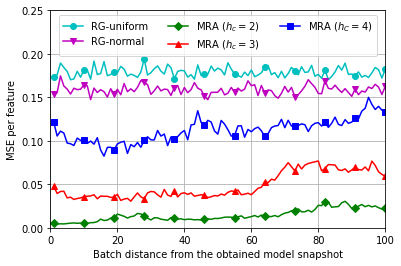

In [11]:
import numpy as np
import matplotlib.pyplot as plt

log_attack = np.loadtxt("./log/drive-2.csv", delimiter=",")
layer3 = np.loadtxt("./log/drive-3.csv", delimiter=",")[:,2]
layer4 = np.loadtxt("./log/drive-4.csv", delimiter=",")[:,2]

plt.xlim([0,100])
plt.ylim([0,0.25])
plt.grid()
plt.ylabel('MSE per feature')
plt.xlabel('Batch distance from the obtained model snapshot')
ran = [i+1 for i in range(100)]
plt.plot(
    ran, log_attack[:,0], 'co-',
    ran, log_attack[:,1], 'mv-',
    ran, log_attack[:,2], 'gD-',
    ran, layer3, 'r^-',
    ran, layer4, 'bs-',
    markevery=np.arange(0, 101, 9))
plt.legend(['RG-uniform', 'RG-normal', 'MRA ($h_c=2$)', 'MRA ($h_c=3$)', 'MRA ($h_C=4$)'], loc='upper center', ncol=3)
plt.savefig("fig/drive-234.pdf", bbox_inches='tight')